In [49]:
import pandas as pd
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('./Serie_A_2022_2023.csv')
df

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,I1,13/08/2022,17:30,Milan,Udinese,4,2,H,2,2,...,2.16,-1.25,1.98,1.92,2.02,1.91,2.17,1.94,2.06,1.81
1,I1,13/08/2022,17:30,Sampdoria,Atalanta,0,2,A,0,1,...,2.24,0.75,2.07,1.83,2.11,1.82,2.13,1.87,2.06,1.82
2,I1,13/08/2022,19:45,Lecce,Inter,1,2,A,0,1,...,2.55,1.50,1.90,2.00,1.91,2.02,1.96,2.06,1.89,1.97
3,I1,13/08/2022,19:45,Monza,Torino,1,2,A,0,1,...,1.75,0.00,1.79,2.11,1.80,2.15,1.88,2.16,1.83,2.06
4,I1,14/08/2022,17:30,Fiorentina,Cremonese,3,2,H,2,1,...,2.09,-1.00,2.02,1.88,2.06,1.87,2.07,1.97,1.99,1.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,I1,12/03/2023,11:30,Lecce,Torino,0,2,A,0,2,...,1.38,0.00,1.89,2.04,1.92,2.01,1.95,2.04,1.89,1.99
255,I1,12/03/2023,14:00,Cremonese,Fiorentina,0,2,A,0,1,...,1.86,0.75,1.98,1.95,1.98,1.94,1.98,2.10,1.88,2.00
256,I1,12/03/2023,14:00,Verona,Monza,1,1,D,0,0,...,1.62,-0.25,2.15,1.79,2.20,1.76,2.20,1.82,2.13,1.77
257,I1,12/03/2023,17:00,Roma,Sassuolo,3,4,A,1,3,...,1.76,-0.75,1.98,1.95,1.98,1.93,2.00,2.01,1.93,1.94


In [67]:
df.loc[(df.HomeTeam == 'Empoli') & (df.AwayTeam == 'Cremonese'),'Date'] = '12/11/2022'
df['year'] = pd.to_datetime(df.Date, format='%d/%m/%Y').dt.year
df['month'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.month
df['day'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.day
df['week'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.week
df['weekday'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.weekday

/tmp/ipykernel_180/2273889262.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.week


In [69]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHA,AvgCAHH,AvgCAHA,year,month,day,FTG,week,weekday,giornata
0,I1,13/08/2022,17:30,Milan,Udinese,4,2,H,2,2,...,1.94,2.06,1.81,2022,8,13,6,32,5,1.0
1,I1,13/08/2022,17:30,Sampdoria,Atalanta,0,2,A,0,1,...,1.87,2.06,1.82,2022,8,13,2,32,5,1.0
2,I1,13/08/2022,19:45,Lecce,Inter,1,2,A,0,1,...,2.06,1.89,1.97,2022,8,13,3,32,5,1.0
3,I1,13/08/2022,19:45,Monza,Torino,1,2,A,0,1,...,2.16,1.83,2.06,2022,8,13,3,32,5,1.0
4,I1,14/08/2022,17:30,Fiorentina,Cremonese,3,2,H,2,1,...,1.97,1.99,1.87,2022,8,14,5,32,6,1.0


In [70]:
df['FTG'] = df['FTHG'] + df['FTAG']

In [73]:
df = df.sort_values(['year', 'month', 'day'])

# Assign sequential week numbers to blocks of days from Thursday to Wednesday
giornata = 1
curr_day = (2020,1,1,-1,-1)
infrasettimanale = False
for i, row in df.iterrows():
    if row['week'] != curr_day[3] and abs(curr_day[4] - row['weekday']) < 6: 
        giornata += 1
    if row['week'] == curr_day[3] and abs(curr_day[4] - row['weekday']) > 1: 
        giornata += 1
    curr_day = (row['year'], row['month'], row['day'], row['week'], row['weekday'])
    df.at[i, 'giornata'] = giornata

In [75]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHA,AvgCAHH,AvgCAHA,year,month,day,FTG,week,weekday,giornata
0,I1,13/08/2022,17:30,Milan,Udinese,4,2,H,2,2,...,1.94,2.06,1.81,2022,8,13,6,32,5,1.0
1,I1,13/08/2022,17:30,Sampdoria,Atalanta,0,2,A,0,1,...,1.87,2.06,1.82,2022,8,13,2,32,5,1.0
2,I1,13/08/2022,19:45,Lecce,Inter,1,2,A,0,1,...,2.06,1.89,1.97,2022,8,13,3,32,5,1.0
3,I1,13/08/2022,19:45,Monza,Torino,1,2,A,0,1,...,2.16,1.83,2.06,2022,8,13,3,32,5,1.0
4,I1,14/08/2022,17:30,Fiorentina,Cremonese,3,2,H,2,1,...,1.97,1.99,1.87,2022,8,14,5,32,6,1.0


In [74]:
df.tail()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHA,AvgCAHH,AvgCAHA,year,month,day,FTG,week,weekday,giornata
254,I1,12/03/2023,11:30,Lecce,Torino,0,2,A,0,2,...,2.04,1.89,1.99,2023,3,12,2,10,6,26.0
255,I1,12/03/2023,14:00,Cremonese,Fiorentina,0,2,A,0,1,...,2.10,1.88,2.00,2023,3,12,2,10,6,26.0
256,I1,12/03/2023,14:00,Verona,Monza,1,1,D,0,0,...,1.82,2.13,1.77,2023,3,12,2,10,6,26.0
257,I1,12/03/2023,17:00,Roma,Sassuolo,3,4,A,1,3,...,2.01,1.93,1.94,2023,3,12,7,10,6,26.0
258,I1,12/03/2023,19:45,Juventus,Sampdoria,4,2,H,2,2,...,2.09,1.85,2.02,2023,3,12,6,10,6,26.0


<Axes: xlabel='giornata'>

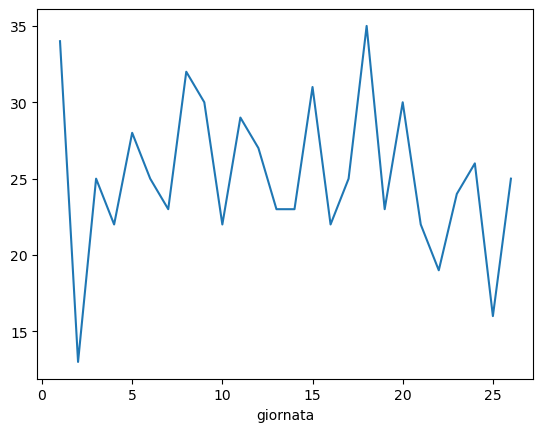

In [80]:
df[['giornata','FTG','FTHG','FTAG']].groupby(['giornata']).sum().FTG.plot()